In [7]:
!pip install torchvision


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.6 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 6.9 MB/s eta 0:00:00


In [3]:
!pip install torch

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/204.1 MB 3.4 MB/s eta 0:01:01
   ---------------------------------------- 1.3/204.1 MB 2.9 MB/s eta 0:01:10
   ---------------------------------------- 2.1/204.1 MB 3.4 MB/s eta 0:01:01
    --------------------------------------- 2.9/204.1 MB 3.6 MB/s eta 0:00:56
    --------------------------------------- 4.2/204.1 MB 4.0 MB/s eta 0:00:51
   - -------------------------------------- 5.5/204.1 MB 4.4 MB/s eta 0:00:46
   - -------------------------------------- 6.6/204.1 MB 4.4 MB/s eta 0:00:45
   - -------------------------------------- 8.1/204.1 MB 4.9 MB/s eta 0:00:41
   - -------------------------------------- 9.7/204.1 MB 5.4 MB/s eta 0:00:37
   -- ------------------------------------- 10.7/204.1 MB 5.1 MB/s eta 0:00:39
   -- ------------------------------------- 11.5/204.1 MB 5.0 MB/s eta 0:00:3

Installed necessary libraries and now definig the image transformation like resizing, flipping and rotating and converting the imges to tensor
before normalizing

In [2]:

# Load your dataframe that contains the product details
import pandas as pd
styles_df = pd.read_csv('../data/cleaned/cleaned_styles.csv',on_bad_lines='skip')  # Replace with your actual file path

In [3]:
# Define the image directory path
image_dir = '../data/raw/fashion-dataset/images'

import os
print(os.listdir(image_dir)[:5])  # see if files like '1234.jpg' show up


['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']


Now encoding the using labelencoding to convert all categorical attributes to numerical

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# First, initialize the label encoders
label_encoder_baseColour = LabelEncoder()
label_encoder_articleType = LabelEncoder()
label_encoder_season = LabelEncoder()
label_encoder_gender = LabelEncoder()

# Fit the label encoders on the entire dataframe to cover both train and validation labels
styles_df['baseColour'] = label_encoder_baseColour.fit_transform(styles_df['baseColour'].astype(str))
styles_df['articleType'] = label_encoder_articleType.fit_transform(styles_df['articleType'].astype(str))
styles_df['season'] = label_encoder_season.fit_transform(styles_df['season'].astype(str))
styles_df['gender'] = label_encoder_gender.fit_transform(styles_df['gender'].astype(str))

# Now split the data into train and validation
train_df, val_df = train_test_split(styles_df, test_size=0.2, random_state=42)






Transforming the image so that it helps in classification 

In [5]:

from torchvision import transforms



# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Flip images horizontally for augmentation
    transforms.RandomRotation(15),  # Rotate images by 15 degrees for augmentation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])




created a custom dataset class to streamline classification and loaded the dataframe with details and the image file contains the images
next lets append.jpg since the images have .jpg and ID in the styles file doesnt have the .jpg extension


Created a dataloader which loads data as the name suggests to load and validate data

In [6]:
# Assuming 'id' column contains integers
# Add file extension if missing
import os
# Create the image_path column from the id column
train_df['image_path'] = train_df['id'].astype(str) + '.jpg'

# Clean paths and filter out missing image files
train_df['image_path'] = train_df['image_path'].apply(lambda x: x.strip())
train_df = train_df[train_df['image_path'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

print(train_df.columns)
print(train_df.head())










Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'month',
       'season_relevance', 'name_length', 'image_path'],
      dtype='object')
          id  gender masterCategory subCategory  articleType  baseColour  \
15558  37789       2        Apparel     Topwear          104          16   
7759    4654       4       Footwear      Sandal          111          25   
43210  36979       4    Accessories        Bags           22          32   
6870   13501       2        Apparel     Topwear          134          44   
33054  39266       2       Footwear       Shoes           19           1   

       season  year   usage                      productDisplayName  month  \
15558       3  2012  Formal  John Players Men Formal Lavender Shirt    6.0   
7759        3  2011  Casual       ADIDAS Women Receptor Navy Sandal    6.0   
43210       0  2012  Casual         Lino Perros Women Purple Clutch    NaN   
68

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os

# Create a custom dataset class
class FashionDataset(Dataset):
    def __init__(self, train_df, image_dir, transform=None):
        self.dataframe = train_df.reset_index(drop=True)  # Ensure clean indexing
        self.image_dir = image_dir
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Load image
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Extract label-encoded values
        label_baseColour = int(row['baseColour'])
        label_articleType = int(row['articleType'])
        label_season = int(row['season'])
        label_gender = int(row['gender'])

        return image, (label_baseColour, label_articleType, label_season, label_gender)

     



# Create DataLoader for training and validation
train_dataset = FashionDataset(train_df, image_dir, transform)
val_dataset = FashionDataset(val_df, image_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    



Now for defining the model I will be choosing ResNet18 since its something light and its a good mix of speed & performance

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiOutputModel(nn.Module):
    def __init__(self, num_baseColour, num_articleType, num_season, num_gender):
        super(MultiOutputModel, self).__init__()
        
        # Load a pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)
        
        # Replace the fully connected layer (fc) with a custom one
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Separate output layers for each attribute
        self.color_output = nn.Linear(256, num_baseColour)
        self.article_type_output = nn.Linear(256, num_articleType)
        self.season_output = nn.Linear(256, num_season)
        self.gender_output = nn.Linear(256, num_gender)
    
    def forward(self, x):
        # Feature extraction through ResNet
        x = self.resnet(x)
        
        # Separate outputs for each attribute
        baseColour = self.colour_output(x)
        articleType = self.article_type_output(x)
        season = self.season_output(x)
        gender = self.gender_output(x)
        
        return baseColour, articleType, season, gender


Now Finally time to handle the imbalances we observed during the EDA Hence here we will calculate the weight using compute_class_weight function
from sklearn

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# For each attribute, we calculate the class weights
def calculate_class_weights(df, attribute):
    # Calculate the class weights based on the distribution in the training data
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df[attribute]), y=df[attribute])
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    return class_weights

# Calculate class weights for each target attribute
baseColour_weights = calculate_class_weights(train_df, 'baseColour')  # Replace with the actual column name
articleType_weights = calculate_class_weights(train_df, 'articleType')  # Replace with the actual column name
season_weights = calculate_class_weights(train_df, 'season')  # Replace with the actual column name
gender_weights = calculate_class_weights(train_df, 'gender')  # Replace with the actual column name

# Print the class weights for each attribute
print("BaseColour Weights: ", baseColour_weights)
print("ArticleType Weights: ", articleType_weights)
print("Season Weights: ", season_weights)
print("Gender Weights: ", gender_weights)


BaseColour Weights:  tensor([1.2581e+00, 9.9255e-02, 1.9303e-01, 9.9038e+00, 2.7394e-01, 2.3409e+01,
        4.1757e+00, 3.3587e+01, 1.0880e+01, 2.4760e+00, 1.9312e+02, 1.5327e+00,
        4.5683e-01, 3.5797e-01, 6.6595e+00, 7.1528e+00, 6.4916e+00, 1.5450e+02,
        7.4279e+00, 1.7477e+00, 3.2188e+01, 2.2721e+01, 2.3769e+00, 6.4375e+01,
        1.0032e+01, 5.3571e-01, 4.8281e+01, 5.1500e+00, 2.2721e+00, 1.8525e+00,
        4.7393e+00, 5.2231e-01, 5.9837e-01, 3.8995e-01, 3.3587e+01, 1.6436e+01,
        4.8281e+01, 9.1204e-01, 5.2911e+00, 3.1024e+00, 8.6798e+00, 9.6562e+01,
        8.3967e+00, 1.3795e+01, 1.7422e-01, 1.2769e+00])
ArticleType Weights:  tensor([3.4057e+00, 2.2911e+01, 4.4844e-01, 3.3161e+00, 2.2911e+01, 1.4825e+01,
        6.3005e+01, 3.8185e-01, 3.6003e+01, 6.3005e+01, 2.5202e+02, 2.1002e+01,
        5.8610e+00, 6.5122e-01, 5.0404e+00, 3.7008e-01, 7.2006e+00, 1.9386e+00,
        1.1614e+00, 1.1161e-01, 9.0008e+00, 6.3005e+01, 1.0816e+00, 6.3005e+00,
        2.8002e+01, 

Since we converted the parameters into weight to handle imbalances and focus on underrepresented data
lets define loss function and check the value

In [10]:
import torch.nn as nn

# Loss functions for each output with class weights
baseColor_criterion = nn.CrossEntropyLoss(weight=baseColour_weights)
articleType_criterion = nn.CrossEntropyLoss(weight=articleType_weights)
season_criterion = nn.CrossEntropyLoss(weight=season_weights)
gender_criterion = nn.CrossEntropyLoss(weight=gender_weights)


Before we move ahead with training the model performing visual sanity check  to verify if the images are loaded properly from the dataloader with proper function

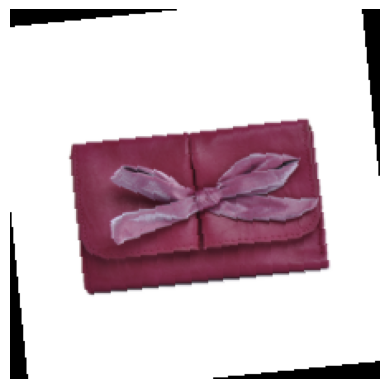

BaseColour (Decoded): Pink
ArticleType (Decoded): Wallets
Season (Decoded): All
Gender (Decoded): Women


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to denormalize and display an image tensor
def imshow(img):
    # Denormalize using ImageNet mean and std
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
               torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW -> HWC
    plt.axis('off')
    plt.show()

# Get a batch of images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Unpack label tuple
label_baseColour, label_articleType, label_season, label_gender = labels

# Display the first image and its labels
imshow(images[0])
print(f"BaseColour (Decoded): {label_encoder_baseColour.inverse_transform([label_baseColour[0].item()])[0]}")
print(f"ArticleType (Decoded): {label_encoder_articleType.inverse_transform([label_articleType[0].item()])[0]}")
print(f"Season (Decoded): {label_encoder_season.inverse_transform([label_season[0].item()])[0]}")
print(f"Gender (Decoded): {label_encoder_gender.inverse_transform([label_gender[0].item()])[0]}")


In [15]:
# Save the processed train and validation data to CSV
train_df.to_csv("../data/processed/train_encoded_metadata.csv", index=False)
val_df.to_csv("../data/processed/val_encoded_metadata.csv", index=False)


In [20]:
import joblib

# Save label encoders for categorical columns
joblib.dump(label_encoder_baseColour, '../outputs/models/label_encoder_baseColour.pkl')
joblib.dump(label_encoder_articleType, '../outputs/models/label_encoder_articleType.pkl')
joblib.dump(label_encoder_season, '../outputs/models/label_encoder_season.pkl')
joblib.dump(label_encoder_gender, '../outputs/models/label_encoder_gender.pkl')


['../outputs/models/label_encoder_gender.pkl']